In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from itertools import *
from sklearn.metrics import mean_squared_error


In [2]:
data = pd.read_csv("test_assignment_sim.csv")
site_co = pd.read_csv("site_coordinates.csv")
print(data.head(10))
print(site_co.head(10))


   FLOWFACTOR  SPACING  DEP TIME  TOOL       SITE_0       SITE_1       SITE_2  \
0       0.916    0.344    69.289     1  1601.802686  1556.668725  1597.900238   
1       0.916    0.344    69.289     2  1516.411140  1495.080373  1516.482818   
2       0.916    0.344    69.289     3  1478.098433  1457.372553  1483.945610   
3       0.916    0.344    69.289     4  1550.290615  1529.621080  1548.352252   
4       0.957    0.348    70.253     1  1544.883218  1495.156181  1549.023309   
5       0.957    0.348    70.253     2  1489.344728  1446.930510  1481.037064   
6       0.957    0.348    70.253     3  1493.257169  1461.370137  1491.910919   
7       0.957    0.348    70.253     4  1532.502760  1480.940855  1526.419827   
8       0.958    0.346    67.731     1  1510.842000  1455.549246  1509.432032   
9       0.958    0.346    67.731     2  1459.394993  1427.275280  1457.439360   

        SITE_3       SITE_4       SITE_5  ...      SITE_39      SITE_40  \
0  1599.790647  1601.083756  1601

In [3]:

sites_datas = []
for i in range(49):
    sliced = data.iloc[:,[0,1,2,3]].copy()
    sliced['thickness'] = data.iloc[:,i+4]
    sliced['SITE'] = i # in lgb, catagory should be a int
    sliced['S_X'] = site_co['SITE_X'][i]
    sliced['S_Y'] = site_co['SITE_Y'][i]
    sites_datas.append(sliced)

site_thickness = sites_datas[0]
for j in range(1,49):
    site_thickness = pd.concat([site_thickness,sites_datas[j]])

#rearrange columns
clist = list(site_thickness.columns)
clist.append(clist.pop(4))
clist.pop(4)
site_thickness = site_thickness[clist]
site_thickness.reset_index(drop=True)
site_thickness['TOOL'] = site_thickness['TOOL'].astype('category')
site_thickness.info()
site_thickness.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FLOWFACTOR  24500 non-null  float64 
 1   SPACING     24500 non-null  float64 
 2   DEP TIME    24500 non-null  float64 
 3   TOOL        24500 non-null  category
 4   S_X         24500 non-null  float64 
 5   S_Y         24500 non-null  float64 
 6   thickness   24500 non-null  float64 
dtypes: category(1), float64(6)
memory usage: 1.3 MB


,FLOWFACTOR,SPACING,DEP TIME,S_X,S_Y,thickness
count,24500.000000,24500.00000,24500.000000,24500.000000,24500.000000,24500.000000
mean,0.946520,0.34952,70.408920,0.000000,0.000000,1503.164632
std,0.024437,0.00470,1.809077,84001.767395,84001.767395,60.713176
min,0.887000,0.33400,66.373000,-147000.000000,-147000.000000,1314.987107
25%,0.929000,0.34700,69.264000,-69296.500000,-69296.500000,1462.423144
50%,0.948000,0.35000,70.443000,0.000000,0.000000,1506.993545
75%,0.962000,0.35200,71.411000,69296.500000,69296.500000,1544.670201
max,1.003000,0.36300,76.008000,147000.000000,147000.000000,1674.742137


In [4]:
site_thickness.head()

,FLOWFACTOR,SPACING,DEP TIME,TOOL,S_X,S_Y,thickness
0,0.916,0.344,69.289,1,-49000.0,6.000570e-12,1601.802686
1,0.916,0.344,69.289,2,-49000.0,6.000570e-12,1516.411140
2,0.916,0.344,69.289,3,-49000.0,6.000570e-12,1478.098433
3,0.916,0.344,69.289,4,-49000.0,6.000570e-12,1550.290615
4,0.957,0.348,70.253,1,-49000.0,6.000570e-12,1544.883218


In [5]:
# Training data preparation

dftrain,dftest = train_test_split(site_thickness,test_size=0.1)

categorical_features = ['TOOL']
lgb_train = lgb.Dataset(dftrain.drop(['thickness'],axis = 1),label=dftrain['thickness'],
                        categorical_feature = categorical_features,free_raw_data=False)

lgb_valid = lgb.Dataset(dftest.drop(['thickness'],axis = 1),label=dftest['thickness'],
                        categorical_feature = categorical_features,
                        reference=lgb_train,free_raw_data=False)

In [6]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 250,
    'learning_rate': 0.05,
    # 'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 2,
    'verbose': 0,
    'max_depth':25
}
# %%
gbm = lgb.train(params,lgb_train)

gbm.save_model('lgbmodel.txt')

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/anaconda3/envs/tf/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


The rmse of prediction is: 5.818015860250977


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

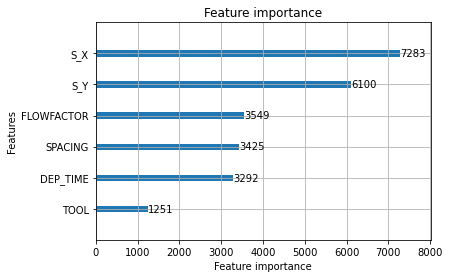

In [7]:

# load model
model = lgb.Booster(model_file='lgbmodel.txt')
 
#prediction
y_pred = model.predict(dftest.drop(['thickness'],axis = 1), num_iteration=gbm.best_iteration) 
print('The rmse of prediction is:', mean_squared_error(dftest['thickness'], y_pred) ** 0.5)
lgb.plot_importance(model)

In [8]:

# Checking extrapolating 1 standard deviation outside of the ranges
FF = [0.86,1.03]
SP = [0.3293,0.368]
DT = [64.563,77.81]
TL = [1,2,3,4]
SX = [147000,-147000,0]
SY = [14700,-147000,0]

exlist = []
for i in product(FF,SP,DT,TL,SX,SY):
    exlist.append(i)

exlist
    


[(0.86, 0.3293, 64.563, 1, 147000, 14700),
 (0.86, 0.3293, 64.563, 1, 147000, -147000),
 (0.86, 0.3293, 64.563, 1, 147000, 0),
 (0.86, 0.3293, 64.563, 1, -147000, 14700),
 (0.86, 0.3293, 64.563, 1, -147000, -147000),
 (0.86, 0.3293, 64.563, 1, -147000, 0),
 (0.86, 0.3293, 64.563, 1, 0, 14700),
 (0.86, 0.3293, 64.563, 1, 0, -147000),
 (0.86, 0.3293, 64.563, 1, 0, 0),
 (0.86, 0.3293, 64.563, 2, 147000, 14700),
 (0.86, 0.3293, 64.563, 2, 147000, -147000),
 (0.86, 0.3293, 64.563, 2, 147000, 0),
 (0.86, 0.3293, 64.563, 2, -147000, 14700),
 (0.86, 0.3293, 64.563, 2, -147000, -147000),
 (0.86, 0.3293, 64.563, 2, -147000, 0),
 (0.86, 0.3293, 64.563, 2, 0, 14700),
 (0.86, 0.3293, 64.563, 2, 0, -147000),
 (0.86, 0.3293, 64.563, 2, 0, 0),
 (0.86, 0.3293, 64.563, 3, 147000, 14700),
 (0.86, 0.3293, 64.563, 3, 147000, -147000),
 (0.86, 0.3293, 64.563, 3, 147000, 0),
 (0.86, 0.3293, 64.563, 3, -147000, 14700),
 (0.86, 0.3293, 64.563, 3, -147000, -147000),
 (0.86, 0.3293, 64.563, 3, -147000, 0),
 (0.8

In [9]:
exdf = pd.DataFrame(exlist,columns=['FF', 'SP','DT','TL','SX','SY'])
exdf['TL'] = exdf['TL'].astype('category')
exdf['SX'] = exdf['SX'].astype('float64')
exdf['SY'] = exdf['SY'].astype('float64')

es_pred = gbm.predict(exdf, num_iteration=gbm.best_iteration) 

exdf.info()

pd.DataFrame(es_pred).describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   FF      288 non-null    float64 
 1   SP      288 non-null    float64 
 2   DT      288 non-null    float64 
 3   TL      288 non-null    category
 4   SX      288 non-null    float64 
 5   SY      288 non-null    float64 
dtypes: category(1), float64(5)
memory usage: 11.9 KB


,0
count,288.000000
mean,1459.084604
std,77.465218
min,1328.864534
25%,1388.379390
50%,1474.845775
75%,1510.537361
max,1632.450054
